In [2]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

from skimage import feature
import cv2
import scipy.signal as signal

from ipywidgets import interact
import ipywidgets as widgets

hr:  3.5


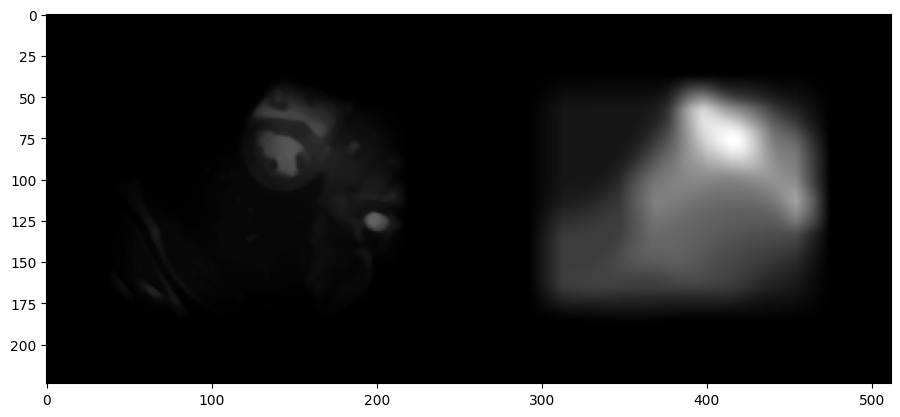

In [3]:
Tps = 0
Slice = 11//3

num = 28

def load_patient(num):
    with open(f'database/patient{num:03}/info.cfg') as f:
        info = [line.replace("\n", "").replace(":", "").split(" ") for line in f]
        for i in range(len(info)):
            if info[i][1].isnumeric():
                info[i][1] = int(info[i][1])

    patient = tio.Subject(
        img=tio.ScalarImage(f'database/patient{num:03}/patient{num:03}_4d.nii.gz'),
        gt=tio.LabelMap(f'database/patient{num:03}/patient{num:03}_frame{dict(info)["ED"]:02}_gt.nii.gz'),
        info = dict(info)
    )
    return patient



def normalize(img4d):
    hist = torch.linspace(0, 1, img4d.shape[1]*img4d.shape[2]*img4d.shape[3], dtype=torch.short)
    hist = torch.pow(hist, 5)*(6-5*hist)*500
    for t in range(img4d.shape[0]):
        indexs = torch.unravel_index(torch.argsort(img4d[t].flatten()), img4d[t].shape)
        img4d[t][indexs] = hist


def tf_mask2(image4d, Tps=Tps, Slice=Slice, heartrate=2):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    # interpolation frequance cardiaque
    heartrate_i = int(heartrate)
    heartrate_f = heartrate - heartrate_i
    filtred[:heartrate_i, :, :, :] = 0.0
    filtred[heartrate_i+1:, :, :, :] = 0.0
    filtred[heartrate_i] *= (1-heartrate_f)
    filtred[heartrate_i+1] *= heartrate_f

    timg2 = torch.abs(torch.fft.ifft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(75,75))

    #mask = cv2.medianBlur(mask,3)
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(75,75)), 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.blur(mask,(21, 21))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    return img_m, mask

patient = load_patient(num)
t_img = patient.img.data.clone().detach()
t_gt = patient.gt.data.clone().detach()
img_m, mask = tf_mask2(t_img, heartrate=t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))
#
# 
# 
# (t_img)
plt.figure().set_figwidth(15)
plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')
plt.imshow(np.concatenate([img_m, mask], axis=1), cmap='gray')

print("hr: ", t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))

In [4]:
def patient_metrics(patient, circles, Slice=Slice):
    t_gt = torch.tensor(patient.gt.data)
    center = (t_gt[0, :, :, Slice]==3).argwhere().mean(axis=0, dtype=torch.float32)
    if circles is None:
        return False, 0., False
    
    dist = torch.dist(center, torch.tensor(circles[:2])) 
    gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)
    hit =  (gt_map[0, int(circles[1]), int(circles[0]), Slice] == 3)

    return True, dist, hit

In [5]:
def tf_mask(image4d, Tps=Tps, Slice=Slice, heartrate=2):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    # interpolation frequance cardiaque
    heartrate_i = int(heartrate)
    heartrate_f = heartrate - heartrate_i
    filtred[:heartrate_i, :, :, :] = 0.0
    filtred[heartrate_i+1:, :, :, :] = 0.0
    filtred[heartrate_i] *= (1-heartrate_f)
    filtred[heartrate_i+1] *= heartrate_f

    timg2 = torch.abs(torch.fft.fft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)

    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(59,59))
    #mask = cv2.dilate(mask, kernel, 1)
    #mask = cv2.dilate(mask, kernel, 1)
    #mask = cv2.erode(mask, kernel, 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    #mask = cv2.erode(mask, kernel, 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    #mask = cv2.blur(mask,(21, 21))

    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(119,119)), 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(130,130)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.blur(mask,(21, 21))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    
    return img_m


In [6]:
def to_rgb(gray):
    return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

def draw_cercles(image4d, circles=None, Tps=Tps, Slice=Slice):
  cimg = np.array(image4d[Tps, :, :, Slice])
  cimg = np.uint8(cimg/np.max(cimg)*255)
  cimg = to_rgb(cimg)
  if circles is not None:
    # print("circles !")
    circles = np.uint16(np.around(circles))
    
    cv2.circle(cimg,(circles[0],circles[1]),circles[2],(0,255,0),1)
    cv2.circle(cimg,(circles[0],circles[1]),1,(255,0,0),2)
  # else:
    # print("no circles !")
  return cimg

def draw_region(imageRGB, lv_seg):
  le_contour = lv_seg - cv2.erode(lv_seg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
  lv_seg = np.bool_(lv_seg)
  le_contour = np.bool_(le_contour)
  imageRGB[lv_seg, 2] = 100
  imageRGB[le_contour, 2] = 255
  return imageRGB

In [7]:
## On remarque que parfois , les parametres de Hough sont trop restructifs et parfois c'est l'inverse.
# On va donc essayer de se rapprocher par dichotomie, des parametres qui nous renvoient un seul cercle par image.
# On fixe minRadius=1 et maxRadius=50.
# On va chercher param1 et param2 tels que le nombre de cercles soit égal à 1.

def best_hough(image):
    param_min = 0
    param_max = 200
    for _ in range(12):
        param_mean = (param_min + param_max) / 2
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circles is not None and len(circles[0])==1:
            return circles[0][0]
        
        elif circles is None:
            param_max = param_mean
        
        else:
            param_min = param_mean

    return None

def best_hough_max(image, param_min=0, param_max=200, max_iter=10):
    param_min = param_min
    param_max = param_max
    out_circles = None
    for _ in range(max_iter):
        param_mean = (param_min + param_max) / 2
        circle = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circle is not None and len(circle[0])==1:
            out_circles = circle[0][0]
            param_min = param_mean

        elif circle is None:
            param_max = param_mean
        
        else:
            param_min = param_mean

    return out_circles

def best_hough2(image):
    for param1 in range(180, 20, -10):
    #for param1 in range(20, 180, 10):
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param1/2,minRadius=1,maxRadius=50)
        
        if circles is not None and len(circles[0])==1:
            return circles[0][0]
    return None

def best_hough3(image): # iterate + max dicothomie
    step = 5
    for param1 in range(180, 20, -step):
    #for param1 in range(20, 180, 10):
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param1/2,minRadius=10,maxRadius=50)
        
        if circles is not None:
            for param in range(param1+step, param1, -1):
                circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                    param1=param,param2=param/2,minRadius=10,maxRadius=50)
                if circles is not None and len(circles[0])==1:
                    return circles[0][0]
            #return best_hough_max(image, param_max=param1+step, param_min=param1, max_iter=10)
    return None

In [8]:
def find_seed(patient, Slice=Slice):
    t_img = torch.tensor(patient.img.data, dtype=torch.float32)
    #normalize(t_img)
    hr = t_img.shape[0] / (patient.info["ES"] - patient.info["ED"])
    img_m = tf_mask(t_img, heartrate=hr, Slice=Slice)
    circles = best_hough3(img_m)
    return circles

def find_seed_muliple_slices(patient, slice, N):
    seeds = []
    #for ds in range(-(N-1)//2, (N+1)//2):
    for slice in range(0, patient.img.data.shape[3]):
        seed = find_seed(patient, Slice=slice)
        if seed is not None:
            seeds += [seed]
    seeds = np.array(seeds)

    if len(seeds)==0:
        return None
    
    dist = []
    for s in seeds:
        d = seeds - s
        d = d*d 
        dist += [np.sum(d)]

    return seeds[np.argmin(dist)]

def recherche_cercles(nb):
    avg_dist = 0
    miss = 0
    accuracie = 0

    for i in range (1,nb+1):
        patient = load_patient(i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        slice = t_img.shape[3] // 2
        circles = find_seed_muliple_slices(patient, slice=slice, N=5)
        c_img = draw_cercles(t_img, circles, Slice=slice)
        found, dist, hit  = patient_metrics(patient, circles, Slice=slice)

        miss += not found
        avg_dist += dist 
        accuracie += int(hit)
        if not hit :
            print(i)
        cv2.imwrite(f'test_seed/cercles_{i:03d}.png', c_img)
    avg_dist /= nb - miss
   
    print(f"\n-= results =-\n accuracie: {round(accuracie / nb * 100, 1)}% (over found circles: {round(accuracie / (nb-miss) * 100, 1)})\n miss: {miss} \n avg dist: {avg_dist}\n-===========-")


In [9]:
recherche_cercles(10)

C:\Users\debat\AppData\Local\Temp\ipykernel_12800\2425451726.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_12800\2425451726.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_12800\4213711568.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)



-= results =-
 accuracie: 100.0% (over found circles: 100.0)
 miss: 0 
 avg dist: 33.23106002807617
-===========-


# LV Segmentation

In [10]:
def dice(patient, lv_seg, Slice=Slice):
    t_gt = torch.tensor(patient.gt.data)
    gt_map = t_gt[0, :, :, Slice]
    gt_map = (gt_map == 3)

    lv_seg = np.bool_(lv_seg)
    gt_map = np.bool_(gt_map)
    inter = np.sum(lv_seg & gt_map)
    
    return 2*inter / (np.sum(lv_seg) + np.sum(gt_map))


In [11]:
from collections import deque

def region_growth(image, seed, error=10):
    H,L=image.shape
    
    
    # estimate mean
    start_moy = []
    for i in range(-2, 3, 1):
        for j in range(-2, 3, 1):
            start_moy += [image[seed[1]+i,seed[0]+j]]
    moy = np.median(start_moy)

    # region growing
    to_explore = deque()
    to_explore.append(np.array([seed]))

    dxy = np.array([[0,-1],[-1,0],[1,0],[0,1]])

    left_V = np.zeros_like(image)
    valide = (moy - image < error)
    valide[0, :] = False 
    valide[H-1, :] = False
    valide[:, 0] = False 
    valide[:, L-1] = False
    while to_explore:
        pos = to_explore.popleft()
        pos_test = dxy + pos
        pos_valide = pos_test[valide[pos_test[:, 1], pos_test[:, 0]]]
        pos_good = pos_valide[np.logical_not(left_V[pos_valide[:, 1], pos_valide[:, 0]])]
                        
        left_V[pos_good[:, 1], pos_good[:, 0]] = 1
        for p in pos_good:
            to_explore.append(p)
       
    taille = np.sum(left_V)
    return left_V, taille

def region_growth(image, seed, error=10):
    H,L=image.shape
    
    # estimate mean
    start_moy = []
    for i in range(-2, 3, 1):
        for j in range(-2, 3, 1):
            start_moy += [image[seed[1]+i,seed[0]+j]]
    moy = np.median(start_moy)

    # region growing
    to_explore = deque()
    to_explore.append(np.array(seed))

    dxy = np.array([[0,-1],[-1,0],[1,0],[0,1]])

    left_V = np.zeros_like(image)
    valide = (moy - image < error)
    valide[0, :] = False 
    valide[H-1, :] = False
    valide[:, 0] = False 
    valide[:, L-1] = False
    while to_explore:
        pos = to_explore.popleft()
        x, y = pos
        if valide[y, x] and not left_V[y, x]:
            left_V[y, x] = 1
            for p in dxy + pos:
                to_explore.append(p)
       
    taille = np.sum(left_V)
    return left_V, taille


C:\Users\debat\AppData\Local\Temp\ipykernel_12800\471833149.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)


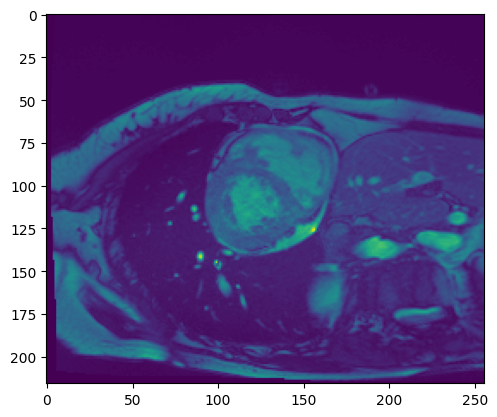

taille: 670.0


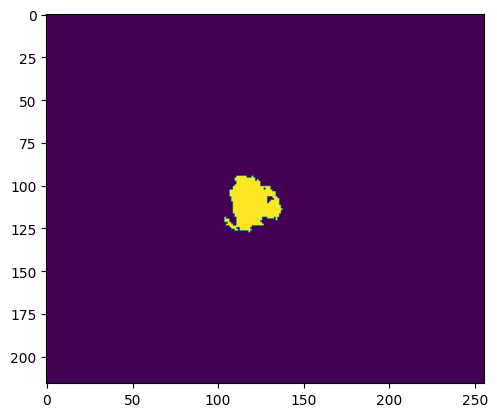

In [17]:
patient = load_patient(98)
t_img = torch.tensor(patient.img.data, dtype=torch.float32)
img = t_img[Tps,:,:,Slice]

plt.imshow(img)
plt.show()

full_seed = find_seed(patient)
seed = [int(full_seed[0]), int(full_seed[1])]
lv2, taille = region_growth(np.array(img), seed, 10)
print("taille:", taille)
plt.imshow(lv2)
plt.show()

In [18]:
def region_growth_planarfit(image, seed, error, a, b, c):
    H,L=image.shape
    left_V = np.zeros_like(image)
    visited = np.zeros_like(image, dtype=bool)

    regionplus=[seed]
    xx, yy = np.mgrid[:image.shape[0], :image.shape[1]]
    moy = a*xx + b*yy + c
    
    visited[seed[1],seed[0]]=True
    left_V[seed[1],seed[0]]=1

    while regionplus:
        new_p=[]
        for (x,y) in regionplus:
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    nx,ny=x+dx,y+dy
                    if 0<=nx<L and 0<=ny<H and not visited[ny,nx]:
                        if abs(image[ny,nx]-moy[ny, nx])<error:
                            new_p.append((nx,ny))
                            visited[ny,nx]=True
                            left_V[ny,nx]=1
        regionplus.extend(new_p)
        regionplus=new_p
        
    taille = np.sum(left_V)
    return left_V, taille, moy



In [30]:
def leftv_seg(patient, Tps=Tps, Slice=Slice):
    full_seed = find_seed_muliple_slices(patient, slice=Slice, N=5)
    if full_seed is None:
        return None
    
    seed = [int(full_seed[0]), int(full_seed[1])]
    rayon = full_seed[2]
    t_img = torch.tensor(patient.img.data)
    img = t_img[Tps,:,:,Slice]
    xx, yy = np.mgrid[:img.shape[0], :img.shape[1]]
    circle = (xx - seed[1]) ** 2 + (yy - seed[0]) ** 2
    circle_map = np.zeros(img.shape, np.bool_)
    circle_map[circle < rayon*rayon] = True

    treshold = 0
    dices = []

    step = 5
    for treshold in range(5, 150, step):
        lv_seg, taille_1 = region_growth(np.array(img), seed, treshold)
        lv_seg = np.bool_(lv_seg)
        
        inter = np.sum(lv_seg & circle_map)
        diff_ext = np.sum(lv_seg & np.logical_not(circle_map))
        dice =  (2*inter-diff_ext) / (np.sum(lv_seg) + np.sum(circle_map))
        dices += [(dice, treshold)]

    treshold = max(dices)[1]
    lv_seg, taille_1 = region_growth(np.array(img), seed, treshold)
    return lv_seg

def fit_plane(image, lv_seg):
    idxs = np.argwhere(lv_seg == 1)
    X = np.ones((len(idxs), 3))
    X[:, :2] = idxs 
    Y = image[idxs[:, 0], idxs[:, 1]]
    (a, b, c),_,_,_ = np.linalg.lstsq(X, Y)
    return a, b, c
    

In [35]:
def recherche_lv(nb):
    avg_dist = 0
    miss = 0
    accuracie = 0
    rad = []
    avg_dice = 0
    for i in range (1,nb+1):
        patient = load_patient(i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        t_gt = torch.tensor(patient.gt.data, dtype=torch.float32)
        slice = t_img.shape[3] // 2
        circles = find_seed_muliple_slices(patient, slice=slice, N=5)
        lv_seg = leftv_seg(patient, Slice=slice)
        if lv_seg is None:
            miss += 1
            continue
        c_img = draw_cercles(t_img, circles, Slice=slice)
        c_img = draw_region(c_img, lv_seg)
        found, dist, hit  = patient_metrics(patient, circles, Slice=slice)

        miss += not found
        avg_dist += dist 
        accuracie += int(hit) 

        
        cv2.imwrite(f'training_segmentation/cercles_{i:03d}.png', c_img)
        dice_score = dice(patient, lv_seg, slice)
        avg_dice += dice_score
        if dice_score < 0.2:
            print(f"{i} : {found} {dist} {hit} and Dice: {dice_score}")
    avg_dist /= nb - miss
    avg_dice /= nb
    print(f"\n-= results =-\n accuracie: {round(accuracie / nb * 100, 1)}% (over found circles: {round(accuracie / (nb-miss) * 100, 1)})\n miss: {miss} \n avg dist: {avg_dist}\n avg dice: {avg_dice}\n-===========-")


In [37]:
recherche_lv(100) #2% d'erreur

C:\Users\debat\AppData\Local\Temp\ipykernel_12800\1790440137.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_12800\1790440137.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_gt = torch.tensor(patient.gt.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_12800\2425451726.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Loc


-= results =-
 accuracie: 99.0% (over found circles: 99.0)
 miss: 0 
 avg dist: 40.91071701049805
 avg dice: 0.8605883354837442
-===========-


## speed optim

In [27]:
!pip install line_profiler
%load_ext line_profiler


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
%lprun -f leftv_seg recherche_lv(5)


C:\Users\debat\AppData\Local\Temp\ipykernel_10568\955882630.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_10568\955882630.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_gt = torch.tensor(patient.gt.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_10568\2425451726.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local


-= results =-
 accuracie: 100.0% (over found circles: 100.0)
 miss: 0 
 avg dist: 33.8418083190918
 avg dice: 0.8615032847853861
-===========-


Timer unit: 1e-07 s

Total time: 3.66096 s
File: C:\Users\debat\AppData\Local\Temp\ipykernel_10568\4078058561.py
Function: leftv_seg at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def leftv_seg(patient, Tps=Tps, Slice=Slice):
     2         5   10149889.0    2e+06     27.7      full_seed = find_seed(patient, Slice=Slice)
     3         5         59.0     11.8      0.0      if full_seed is None:
     4                                                   return None
     5                                               
     6         5        366.0     73.2      0.0      seed = [int(full_seed[0]), int(full_seed[1])]
     7         5         48.0      9.6      0.0      rayon = full_seed[2]
     8         5     214395.0  42879.0      0.6      t_img = torch.tensor(patient.img.data)
     9         5       4160.0    832.0      0.0      img = t_img[Tps,:,:,Slice]
    10         5      27176.0   5435.2      0.1      xx, y

## To do list

- faire une fonction de propagation des seeds qui prend en entrée une image ou placer une seed et une image avec une seed placée. ET appliquer hough dans un voisinage.
- faire une autre fonction qui determine une seed qui est le minimum des distances moyennes à 5 autres seeds.

- tester la segmentation par region growing sur un gradient de l'image (méthodes de edge based region growing)
- tester des normalisations blablabla de l'image pour voir si meilleures performances.